# Домашнее задание №9
*Задание выполнил* **Чащин Артем Максимович**

*Курс:* **3**, *группа:* **МФТИ-1**

**[GitHub](https://github.com/alexvilno/PSU_TIMESERIES/tree/HW2)**

**[Telegram](https://t.me/artemchashchin)**

## Оглавление
* [Генерим 20 сигналов (временных рядов), 2 класса по 10 образцов в каждом](#1)
* [Ищем шейплеты](#2)
* [Формируем датасет для обучения классификатора](#3)
* [Обучаем KNN dtw](#4)


### Генерим 20 сигналов (временных рядов), 2 класса по 10 образцов в каждом <a id="1"></a>

In [299]:
import matplotlib.pyplot as plt
import numpy as np
import random

myseed = 13072003
random.seed(myseed)
np.random.seed(myseed)

In [300]:
import numpy as np
from typing import List, Tuple

def generate_timeseries(time: np.ndarray, num_series: int) -> Tuple[List[List[float]], List[List[float]]]:
    """Генерирует временные ряды.

    Аргументы:
    time (np.ndarray): Одномерный массив временных меток.
    num_series (int): Количество генерируемых временных рядов.

    Возвращает:
    Tuple[List[List[float]], List[List[float]]]: Кортеж из двух списков списков значений временных рядов:
                                                 (sin_ts, cos_ts).

    Raises:
    ValueError: Если `time` не является одномерным массивом.
    ValueError: Если `num_series` не является положительным числом.
    """

    if len(time.shape) != 1:
        raise ValueError("Аргумент 'time' должен быть одномерным массивом.")

    if num_series <= 0:
        raise ValueError("Аргумент 'num_series' должен быть положительным числом.")

    sin_ts = []
    cos_ts = []
    rand = np.random.random(size=num_series)

    for i in range(num_series):
        cos_ts.append((-0.5 * (1 - rand[i] / 10) * np.cos(np.pi * 0.2 * time + rand[i]) * (1 + rand[i] * 0.2)).tolist())

    for i in range(num_series):
        sin_ts.append((0.5 * (1 - rand[i] / 10) * np.sin(time + rand[i] + 0.3) * (1 + rand[i] * 0.2)).tolist())

    return sin_ts, cos_ts

In [301]:
from typing import List
import matplotlib.pyplot as plt

def plot_timeseries(sin_ts: List[List[float]], cos_ts: List[List[float]]) -> None:
    """Отображает графики временных рядов на одном графике.

    Аргументы:
    sin_ts (List[List[float]]): Список списков значений временного ряда sin.
    cos_ts (List[List[float]]): Список списков значений временного ряда cos.

    Возвращает:
    None

    Raises:
    ValueError: Если `sin_ts` или `cos_ts` не являются списками.
    ValueError: Если в `sin_ts` или `cos_ts` встречается несписковой элемент.
    """
    if not isinstance(sin_ts, list) or not isinstance(cos_ts, list):
        raise ValueError("Аргументы 'sin_ts' и 'cos_ts' должны быть списками.")

    for ts in sin_ts + cos_ts:
        if not isinstance(ts, list):
            raise ValueError("Элементы 'sin_ts' и 'cos_ts' должны быть списками.")
    try:
        plt.figure(figsize=(10, 5))

        for i, ts in enumerate(sin_ts):
            plt.plot(ts, '-r', label='sin_ts' if i == 0 else None)

        for i, ts in enumerate(cos_ts):
            plt.plot(ts, '-g', label='cos_ts' if i == 0 else None)

        plt.legend()
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.title('Графики временных рядов')
        plt.grid(True)
        plt.show()
    except Exception as err:
        raise err

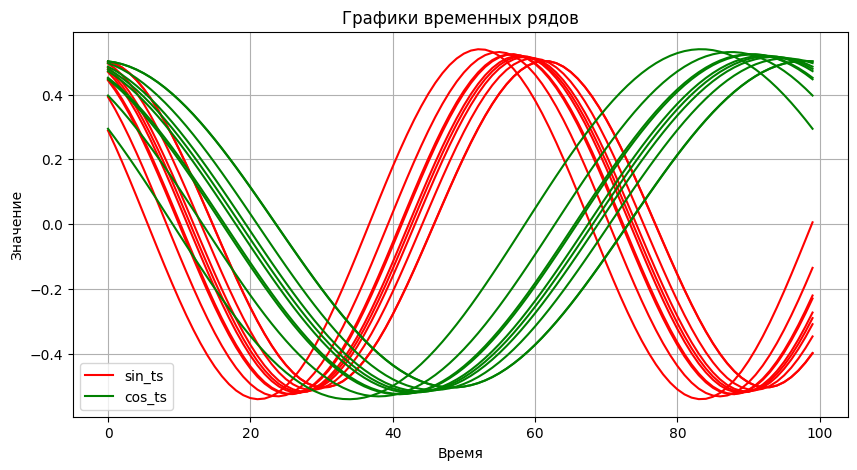

In [302]:
time = np.linspace(-5, 5, num=100)
num_series = 10
sin_ts, cos_ts = generate_timeseries(time, num_series)
plot_timeseries(sin_ts, cos_ts)

### Ищем шейплеты <a id="2"> </a>

In [303]:
from scipy.spatial.distance import euclidean
from typing import List, Tuple
import numpy as np

def distances_func(S: np.ndarray, Wi_l: List[np.ndarray]) -> List[float]:
    """Вычисляет расстояния между временным рядом S и набором кандидатов Wi_l.

    Аргументы:
    S (np.ndarray): Временной ряд S.
    Wi_l (List[np.ndarray]): Список массивов-кандидатов Wi_l.

    Возвращает:
    List[float]: Список расстояний между S и каждым кандидатом из Wi_l.
    """

    distances = [euclidean(S, candidate) for candidate in Wi_l]
    return distances

In [304]:
def find_candidates(ts: np.ndarray, min_l: int = 3, max_l: int = 100) -> List[np.ndarray]:
    """Находит подпоследовательности во временном ряде ts.

    Аргументы:
    ts (np.ndarray): Временной ряд.
    min_l (int): Минимальная длина подпоследовательности (по умолчанию 3).
    max_l (int): Максимальная длина подпоследовательности (по умолчанию 100).

    Возвращает:
    List[np.ndarray]: Список подпоследовательностей, найденных в ts.
    """

    cands = []
    for l in range(min_l, max_l + 1):
        for i in range(len(ts) - l + 1):
            sub_sequence = ts[i:i + l]
            cands.append(sub_sequence)
    return cands

In [305]:
def cand_func(dist: List[float]) -> float:
    """Вычисляет среднее значение корней из расстояний.

    Аргументы:
    dist (List[float]): Список расстояний.

    Возвращает:
    float: Среднее значение корней из расстояний.
    """
    return np.mean(np.sqrt(dist))

In [306]:
def insert_shapelet(
        rShapelets: List[Tuple[np.ndarray, float]], 
        shapelet: Tuple[np.ndarray, float]
    ) -> List[Tuple[np.ndarray, float]]:
    """Вставляет новый шейплет в отсортированный список шейплетов rShapelets.

    Аргументы:
    rShapelets (List[Tuple[np.ndarray, float]]): Отсортированный список шейплетов.
    shapelet (Tuple[np.ndarray, float]): Вставляемый шейплет.

    Возвращает:
    List[Tuple[np.ndarray, float]]: Обновленный список шейплетов с вставленным шейплетом.
    """

    result = []
    i = 0
    for i in range(len(rShapelets)):
        if rShapelets[i][1] <= shapelet[1]:
            result += [rShapelets[i]]
        if rShapelets[i][1] > shapelet[1]:
            if i == 0 or rShapelets[i - 1][1] < shapelet[1]:
                result += [shapelet]
            else:
                result += [rShapelets[i - 1]]
    return result

In [307]:
def merge(
        k: int, 
        kShapelets: List[Tuple[np.ndarray, float]], 
        shapelets: List[Tuple[np.ndarray, float]]
    ) -> List[Tuple[np.ndarray, float]]:
    """Объединяет kShapelets и shapelets, выбирая лучшие k шейплетов.

    Аргументы:
    k (int): Число лучших шейплетов для выбора.
    kShapelets (List[Tuple[np.ndarray, float]]): Лучшие шейплеты на данный момент.
    shapelets (List[Tuple[np.ndarray, float]]): Новые шейплеты для объединения.

    Возвращает:
    List[Tuple[np.ndarray, float]]: Объединенный список лучших шейплетов.
    """

    if len(kShapelets) == 0:
        return shapelets[0:k]
    result = kShapelets
    for shapelet in shapelets:
        if shapelet[1] < kShapelets[len(kShapelets) - 1][1]:
            kShapelets = insert_shapelet(result, shapelet)
    return result

In [308]:
def filter_shapelets(
        x: List[Tuple[np.ndarray, float]], 
        min_val: float = 0.05
    ) -> List[Tuple[np.ndarray, float]]:
    """Фильтрует шейплеты, оставляя только те, у которых значение quality не меньше min_val.

    Аргументы:
    x (List[Tuple[np.ndarray, float]]): Список шейплетов.
    min_val (float): Минимальное значение quality (по умолчанию 0.05).

    Возвращает:
    List[Tuple[np.ndarray, float]]: Отфильтрованный список шейплетов.
    """

    result = []
    for xi in x:
        if xi[1] <= min_val:
            result += [xi]
    return result

In [309]:
def shapelet_selection(
        tseries_list: List[np.ndarray],
        k: int = 50, 
        min_len: int = 3, 
        max_len: int = 100
    ) -> List[Tuple[np.ndarray, float]]:
    """Выбирает лучшие k шейплетов из списка временных рядов tseries_list.

    Аргументы:
    tseries_list (List[np.ndarray]): Список временных рядов.
    k (int): Число лучших шейплетов для выбора (по умолчанию 50).
    min_len (int): Минимальная длина шейплета (по умолчанию 3).
    max_len (int): Максимальная длина шейплета (по умолчанию 100).

    Возвращает:
    List[Tuple[np.ndarray, float]]: Список лучших шейплетов.
    """

    kShapelets = []
    for tseries in tseries_list:
        shapelets = []
        for l in range(min_len, max_len + 1):
            candidates = find_candidates(tseries, min_len, max_len)
            for candidate in candidates:
                distances = distances_func(candidate, candidates)
                quality = cand_func(distances)
                shapelets.append((candidate, quality))
        shapelets = filter_shapelets(shapelets, quality)
        shapelets.sort(key=lambda x: x[1], reverse=True)
        kShapelets = merge(k, kShapelets, shapelets)
    return kShapelets

In [310]:
shapletes_sin= shapelet_selection(sin_ts, k = 20, min_len= 4 , max_len= 4)
shapletes_cos = shapelet_selection(cos_ts, k = 20, min_len= 4 , max_len= 4)

### Формируем датасет для обучения классификатора <a id="3"> </a>

In [311]:
import random

x = []
Y = []
shpletes_qual = shapletes_sin + shapletes_cos

for i in range(len(shpletes_qual)):
    res = list(shpletes_qual[i][0]) + [shpletes_qual[i][1]]  
    x.append(res)
    
    if i < len(shapletes_sin):
        Y.append(1)
    else:
        Y.append(2)

X_train = []
X_test = []
Y_train = []
Y_test = []


indexes = np.arange(len(Y))
random.shuffle(indexes)
for i in range(int(len(Y) * 0.7)):
    X_train.append(x[indexes[i] - 1])
    Y_train.append(Y[indexes[i] - 1])

for i in range(int(len(Y) * 0.7), len(Y)):
    X_test.append(x[indexes[i] - 1])
    Y_test.append(Y[indexes[i] - 1])

print(Y_train, Y_test)

[1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2] [2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2]


### Обучаем KNN dtw <a id="4"> </a>

In [312]:
from pyts.classification import KNeighborsClassifier

clf = KNeighborsClassifier(metric='dtw')
clf.fit(X_train, Y_train)

print(f"Accuracy {clf.score(X_test, Y_test)}")
for i in range(len(Y_test)):
    print(f"{i + 1} объект:")
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(np.array(X_test[i]).reshape(1, -1))[0]}")
    print(f"Истинный класс для предсказаний {Y_test[i]}")

Accuracy 1.0
1 объект:
Вектор вероятности принадлежности к классам [0. 1.]
Истинный класс для предсказаний 2
2 объект:
Вектор вероятности принадлежности к классам [1. 0.]
Истинный класс для предсказаний 1
3 объект:
Вектор вероятности принадлежности к классам [0. 1.]
Истинный класс для предсказаний 2
4 объект:
Вектор вероятности принадлежности к классам [1. 0.]
Истинный класс для предсказаний 1
5 объект:
Вектор вероятности принадлежности к классам [0. 1.]
Истинный класс для предсказаний 2
6 объект:
Вектор вероятности принадлежности к классам [1. 0.]
Истинный класс для предсказаний 1
7 объект:
Вектор вероятности принадлежности к классам [1. 0.]
Истинный класс для предсказаний 1
8 объект:
Вектор вероятности принадлежности к классам [0. 1.]
Истинный класс для предсказаний 2
9 объект:
Вектор вероятности принадлежности к классам [0. 1.]
Истинный класс для предсказаний 2
10 объект:
Вектор вероятности принадлежности к классам [0. 1.]
Истинный класс для предсказаний 2
11 объект:
Вектор вероятно